# Harmonic similarity demo

**Notes for improvements**
- For computational reasons, it is better to start comparing n-grams from the lowest order (e.g. 2, 3) and stop as soon as there are no more elements in common. For instance, if there are no repeated patterns of len 4 between two sequences under comparison, it does not make sense to try  with anything > 4. This can speed up computation of the hsim.
- Instead of saving the actual full ngrams for each track, we should consider creating a table of all the possible ngrams that were found across all the dataset. This  way track A will say "I have ngrams x, y, ..." which can then be read from such a different table. This would reduce the space complexity.
- In addition, to speed up comparison, we should create another table -- using the indices of the previous table (the index for all the ngrams), to save all those tracks that each specific ngram. The mapping is <from the index of the ngram> to the list of all the track (ids) that have that recurring pattern. This should easily allow comparing 1 given track to all the others in one shot, rather than performing trivial 1-to-1 comparisons.
- The current code works on ngrams computed from tracks that were **not** transposed to the same key (considering the current encodings), so the harmonic similarity should be much higher, in principle, once we manage to address this point.
- The second term h_corr of our full measure of harmonic similarity (see Notion) is the most computationally demanding part, because it requires re-computing the recurring patterns from the concatenated sequences. Not supported for the moment, but we can consider as FW, as we will be able to retrieve more matches and increase the whole similarity score.
- **Doing graph analysis of the resulting graph (see the Extra section) seems a very very promising direction!**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import joblib
import networkx as nx
import matplotlib.pyplot as plt

from harmonic_lib import ngram_hsim

## Reading and re-shaping the data

In [3]:
with open("./sonar_ngrams.joblib", "rb") as fo:
    ngrams_bag = joblib.load(fo)

In [4]:
# Map from track name to recurring patterns
ngrams_bag_dict = {list(track_dict.keys())[0]:
    track_dict[list(track_dict.keys())[0]] for track_dict in ngrams_bag}

In [5]:
ngrams_bag_dict["isophonics_0"][:10]  # just an example to visualise

[(103, 105, 81),
 (169, 81, 0),
 (202, 210, 103),
 (103, 73, 103),
 (207, 202, 210),
 (210, 202, 210),
 (81, 0, 210),
 (98, 207, 202),
 (202, 210, 169),
 (210, 98, 207)]

## Computing the similarity: an example

In [6]:
a_rpbag = ngrams_bag_dict["isophonics_0"]
b_rpbag = ngrams_bag_dict["isophonics_155"]

In [7]:
hsim_score, longest_rp = ngram_hsim(a_rpbag, b_rpbag)

print("h_sim = {0:.4f} based on longest recurrent pattern(s): {1}"
      .format(hsim_score, longest_rp))

h_sim = 0.1905 based on longest recurrent pattern(s): [(202, 210, 202, 210, 202)]


## Computing the similarity: all tracks

In [8]:
track_ids = list(ngrams_bag_dict.keys())
hsim_map = {track_id: {} for track_id in track_ids}

In [9]:
for i, track_a in enumerate(track_ids):
    a_rpbag = ngrams_bag_dict[track_a]  # fix for now
    for j in range(i+1, len(track_ids)):  # move ahead
        track_b = track_ids[j]
        b_rpbag = ngrams_bag_dict[track_b]

        hsim, longest_rps = ngram_hsim(a_rpbag, b_rpbag)
        if hsim > 0.:  # save only non-trivial
            hsim_map[track_a][track_b] = hsim
            hsim_map[track_b][track_a] = hsim
        

In [10]:
hsim_map["isophonics_0"]["isophonics_155"]

0.19047619047619047

## Extra

In [11]:
import matplotlib.pyplot as plt

from bokeh.io import output_notebook, show, save
from bokeh.models import Circle, MultiLine, HoverTool, NodesAndLinkedEdges
from bokeh.plotting import figure, from_networkx
from bokeh.palettes import Greys256, Blues256
from bokeh.transform import linear_cmap

output_notebook()


Loading BokehJS ...

In [12]:
G = nx.Graph()

for track_id in track_ids:
    if len(hsim_map[track_id]) > 0:
        G.add_node(track_id)

for track_a in hsim_map:
    for track_b in hsim_map[track_a]:
        if not G.has_edge(track_b, track_a):
            G.add_edge(track_a, track_b,
                weight=hsim_map[track_a][track_b])

In [13]:
# Some basic network analysis
degrees_dict = dict(nx.degree(G))
nx.set_node_attributes(G, name='degree', values=degrees_dict)

degrees = list(degrees_dict.values())

In [83]:
title = 'Harmonic similarity network'
edge_palette = Greys256[::-1]  # inverted grey scale
node_palette = Blues256[::-1]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tools="pan,wheel_zoom,save,reset,tap",
              active_scroll='wheel_zoom', title=title)

# Create a network graph object with spring layout
network_graph = from_networkx(G, nx.spring_layout, scale=10, center=(0, 0))
# Set node and edge palettes
edge_cmap = linear_cmap('weight', edge_palette, 0, 1)
node_cmap = linear_cmap("degree", node_palette, min(degrees), max(degrees))
# Set the colour and size of nodes and edges
network_graph.node_renderer.glyph = Circle(size=10, fill_color=node_cmap)
network_graph.edge_renderer.glyph = MultiLine(
    line_color=edge_cmap,
    line_alpha=0.5, line_width=1)

# Selection behaviour: change of col/size
network_graph.node_renderer.selection_glyph = Circle(
    size=10, fill_color="orange", line_width=2)
network_graph.edge_renderer.selection_glyph = MultiLine(
    line_color="yellow", line_width=2)

network_graph.selection_policy = NodesAndLinkedEdges()
network_graph.inspection_policy = NodesAndLinkedEdges()

# Hovering behaviour: show information
hover_edges = HoverTool(
    tooltips=[("hsim", "@weight")],
    renderers=[network_graph.edge_renderer],
    line_policy="interp")

hover_nodes = HoverTool(
    tooltips=[("track","@index"), ("degree", "@degree")],
    renderers=[network_graph.node_renderer])

#A dd network graph to the plot
plot.renderers.append(network_graph)
plot.add_tools(hover_edges, hover_nodes)

show(plot)
# save(plot, filename=f"test.html")

## Old visualisation: static image

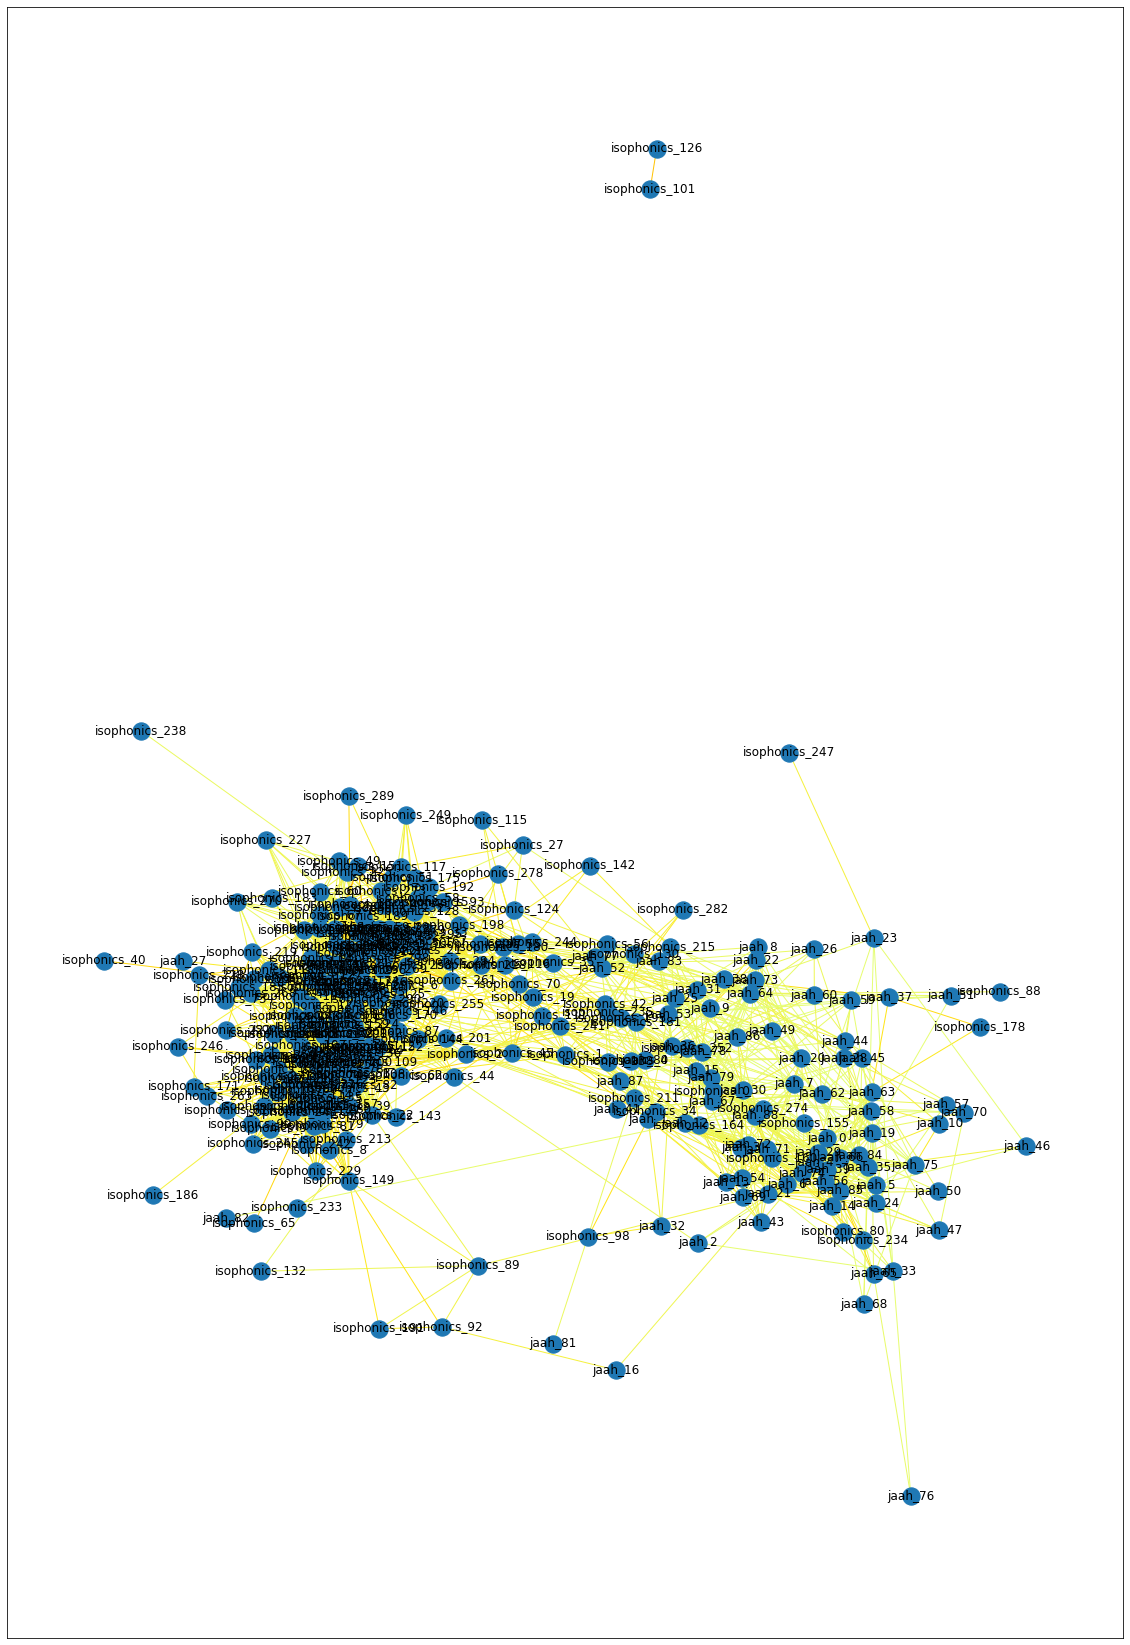

In [17]:
fig, axes = plt.subplots(figsize=(20,30))

position = nx.spring_layout(G)
#labels = nx.get_edge_attributes(G, 'weight')
edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())

nx.draw_networkx_nodes(G, position)
nx.draw_networkx_labels(G, position)

nx.draw_networkx_edges(G, position,
    edge_cmap=plt.cm.Wistia, edge_color=weights)
#nx.draw_networkx_edge_labels(G, position, edge_labels=labels)

plt.show()
